# Document setup

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# Manipulation functions

**Reverse** will reverse the ranking scale (so 5 → 1, 2 → 4, etc.); applied to negative questions

**Adjust** will replace the string answer options with a ranking scale 1-5, will drop unecessary columns, reverse negative questions and rename the row indices to the participants' names for easier comparison

There are two significant outliers, that have been ruled out.

In [3]:
negativeQuestions = ["[I dislike singing]", "[I do not find karaoke amusing]", "[The time goes very slow when I do karaoke]", "[I feel bored]", "[I prefer karaoke without any effects]", "[I quickly get exhausted by new technologies]", "[I do not like karaoke]"]

def reverse(s):
    out = [5 - int(item) + 1 for item in s]
    return out

def adjust(dataframe):
    dataframe.replace({ "Completely agree" : 5,
                        "Somewhat agree" : 4,
                        "Neutral" : 3,
                        "Somewhat disagree" : 2,
                        "Completely disagree" : 1 }, inplace=True)

    dataframe.drop(columns=["Timestamp"], inplace=True)
    
    dataframe[negativeQuestions] = dataframe[negativeQuestions].apply(reverse)

    renameDict = {index : dataframe["Name"][index] for index in range(len(dataframe["Name"]))}
    dataframe = dataframe.rename(index=renameDict).drop(columns=["Name"])
    
    return dataframe

# Data evaluation

In [4]:
resWithout = pd.read_excel("results.xlsx", "without")
resWith = pd.read_excel("results.xlsx", "with")

conditionIndices = [i if resWithout.iloc[i]["Timestamp"] < resWith.iloc[i]["Timestamp"] else -i for i in range(len(resWith))]
C1 = [index for index in conditionIndices if index >= 0]
C2 = [-index for index in conditionIndices if index < 0]

resWithout, resWith = (adjust(resWithout), adjust(resWith))

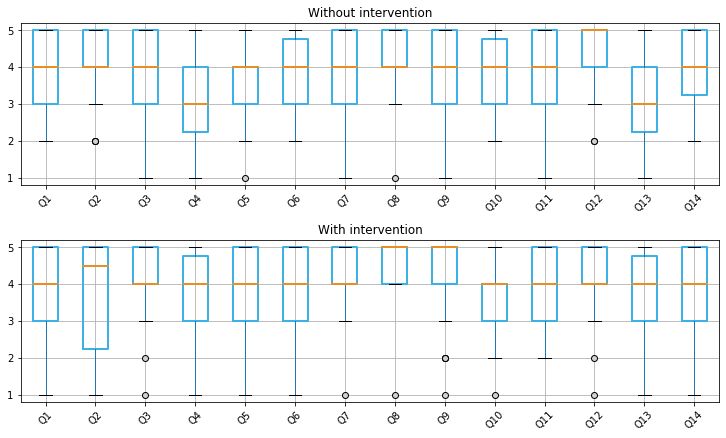

In [5]:
boxprops = dict(color="#3DB1E5", lw=2)
flierprops = dict(marker='o', markerfacecolor='#D1D2D4', linestyle='none')
medianprops = dict(lw=2, color="#E78E26")
fig, axes = plt.subplots(2, figsize=(10, 6))

renameDict = {resWithout.columns[i] : "Q" + str(i+1) for i in range(len(resWithout.columns))}
withoutBoxplot = resWithout.rename(columns=renameDict).boxplot(rot=45,
                                                               ax=axes.flatten()[0],
                                                               boxprops=boxprops,
                                                               flierprops=flierprops,
                                                               medianprops=medianprops,
                                                               color={'medians': '#E78E26',
                                                                      'boxes': '#3DB1E5'})
withoutBoxplot.set_title("Without intervention")

renameDict = {resWith.columns[i] : "Q" + str(i+1) for i in range(len(resWith.columns))}
withBoxplot = resWith.rename(columns=renameDict).boxplot(rot=45,
                                                         ax=axes.flatten()[1],
                                                         boxprops=boxprops,
                                                         flierprops=flierprops,
                                                         medianprops=medianprops,
                                                         color={'medians': '#E78E26',
                                                                'boxes': '#3DB1E5'})
withBoxplot.set_title("With intervention")

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
fig.show()

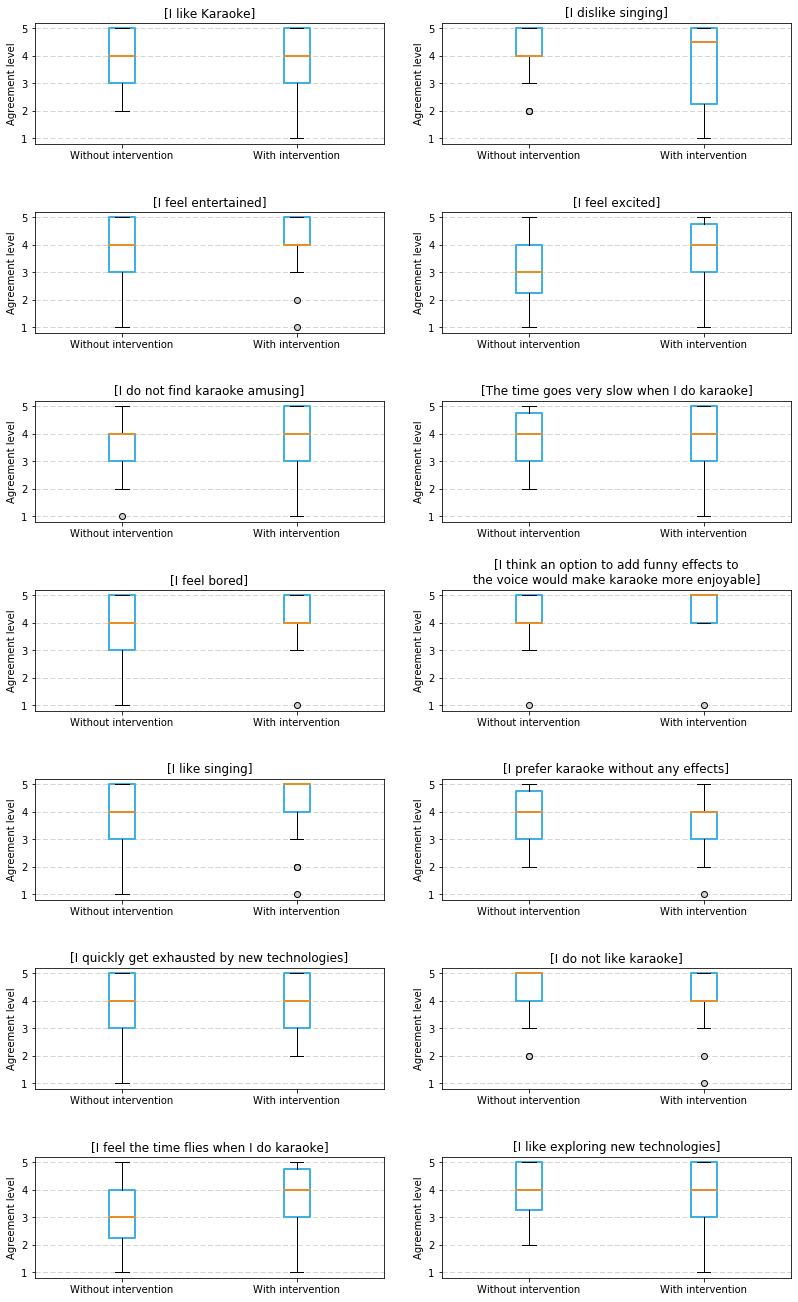

In [6]:
questionBoxplots = []

for i in range(resWith.shape[1]):
    a = pd.DataFrame()
    a['Without'] = resWithout[resWithout.columns[i]]
    a['With'] = resWith[resWith.columns[i]]
    questionBoxplots.append(a)

fig, axes = plt.subplots(ncols=2, nrows=7, figsize=(11, 18))

for i in range(len(questionBoxplots)//2):
    for j in range(2):        
        axes[i][j].axhline(1, dashes=[10, 5], alpha=0.8, color="#999999", lw=0.5)
        axes[i][j].axhline(2, dashes=[10, 5], alpha=0.8, color="#999999", lw=0.5)
        axes[i][j].axhline(3, dashes=[10, 5], alpha=0.8, color="#999999", lw=0.5)
        axes[i][j].axhline(4, dashes=[10, 5], alpha=0.8, color="#999999", lw=0.5)
        axes[i][j].axhline(5, dashes=[10, 5], alpha=0.8, color="#999999", lw=0.5)

        axes[i][j].boxplot(questionBoxplots[i*2+j].transpose(),
                           boxprops=boxprops,
                           flierprops=flierprops,
                           medianprops=medianprops)
        axes[i][j].set(ylabel="Agreement level", xticklabels=["Without intervention", "With intervention"])

        axes[i][j].set_title(resWith.columns[i*2+j] if i*2+j != 7 else "[I think an option to add funny effects to\nthe voice would make karaoke more enjoyable]")
        plt.tight_layout(pad=0.4, w_pad=3.0, h_pad=2.0)

fig.show()

# Compared change in feelings about the experience

The following graph displays the frequency of participants' change in feelings. Positive numbers are essentially stating, that the participant's experience was better while doing karaoke with our intervention, than it was while doing it without the intervention. Negative numbers, on the other hand state, that the participant enjoyed the without-version more.

This dataframe is calculated by summing up all ranked answers per person from both With and Without versions questionnaires and then comparing these values. If the participant has a higher overall score in the With version, it means that they have answered more positively to the questions about their experience.

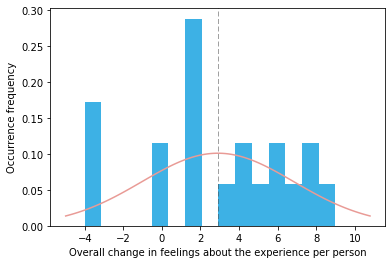

In [7]:
differencesOverall = resWith.sum(axis=1) - resWithout.sum(axis=1)
differencesC1 = differencesOverall[C1]
differencesC2 = differencesOverall[C2]

differencesOverall.drop(["Bianka", "Christian"], inplace=True)
differencesC1.drop(["Bianka"], inplace=True)
differencesC2.drop(["Christian"], inplace=True)

mu = differencesOverall.mean()
variance = differencesOverall.var()
sigma = differencesOverall.std()
x = np.linspace(mu - 2*sigma, mu + 2*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), color="#E99B96")
plt.axvline(x=mu, color="#444444", lw=0.5).set_dashes([10, 5])
plt.hist(differencesOverall, density=True, bins=15, color="#3DB1E5")
plt.xlabel("Overall change in feelings about the experience per person")
plt.ylabel("Occurrence frequency")
plt.show()

## Consideration of relevance between the different condition order

As a part of the within-group experiment design, to remove some of the proposed bias threats, the participants were randomly allocated to the following two conditions:

- C1: Do karaoke *without* intervention, then do karaoke *with* intervention
- C2: Do karaoke *with* intervention, then do karaoke *without* intervention

To see, if there is any significant difference, we compare these two groups:

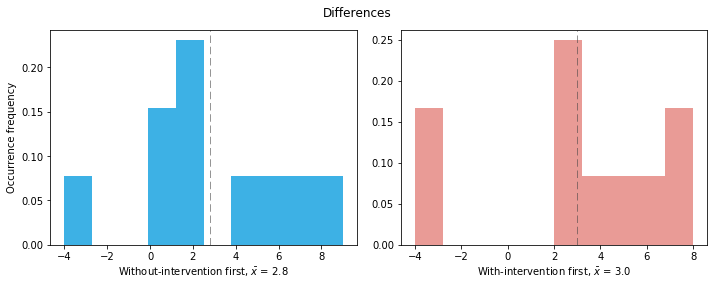

In [8]:
fig, (histC1, histC2) = plt.subplots(1, 2, figsize = (10,4))
meanSign = r"$\bar{x}$"

histC1.hist(differencesC1, density=True, bins=10, color="#3DB1E5")
histC1.set(xlabel=f"Without-intervention first, {meanSign} = {differencesC1.mean()}", ylabel="Occurrence frequency")
histC1.axvline(x=differencesC1.mean(), color="#444444", alpha=0.75, lw=0.75).set_dashes([10, 5])

histC2.hist(differencesC2, density=True, bins=10, color="#E99B96")
histC2.set(xlabel=f"With-intervention first, {meanSign} = {differencesC2.mean()}")
histC2.axvline(x=differencesC2.mean(), color="#444444", alpha=0.75, lw=0.75).set_dashes([10, 5])

plt.suptitle("Differences")
plt.tight_layout(pad=1, w_pad=1.5, h_pad=1.0)
plt.subplots_adjust(top=0.9)

plt.show()

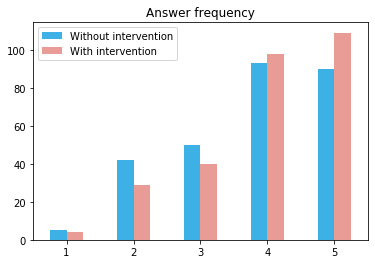

In [9]:
resWithSum = resWith.drop(["Bianka", "Christian"]).apply(pd.Series.value_counts).fillna(0)
resWithoutSum = resWithout.drop(["Bianka", "Christian"]).apply(pd.Series.value_counts).fillna(0)

fqAnswersWith = [int(resWithSum.iloc[x].sum()) for x in range(5)]
fqAnswersWithout = [int(resWithoutSum.iloc[x].sum()) for x in range(5)]

answersWith = pd.DataFrame({"Category" : list(range(1,6)), "Frequency" : fqAnswersWith})
answersWithout = pd.DataFrame({"Category" : list(range(1,6)), "Frequency" : fqAnswersWithout})

answers = pd.DataFrame({'Without intervention' : fqAnswersWithout, 'With intervention' : fqAnswersWith}, index=list(range(1,6)))
answers.plot.bar(title="Answer frequency", rot=0, color=("#3DB1E5", "#E99B96"))

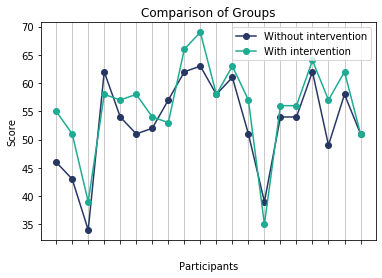

In [10]:
resWithoutCountSum = resWithout.drop(["Bianka", "Christian"]).sum(axis=1)
resWithCountSum = resWith.drop(["Bianka", "Christian"]).sum(axis=1)

plt.plot(resWithoutCountSum, 'o-', label="Without intervention", color="#273764")
plt.plot(resWithCountSum, 'o-', label='With intervention', color="#1FAB93")
plt.grid(axis='x', color="#999999", alpha=0.5, lw=1)
plt.xticks(color="#FFFFFF")
plt.xlabel('Participants')
plt.ylabel('Score')
plt.title('Comparison of Groups')
plt.legend()
plt.show()

In [11]:
print("%.2f" % answersWith.Frequency.var())
print("%.2f" % answersWithout.Frequency.var())

2065.50
1339.50


# Assumptions

## Variance criteria: Levene Test
- This control test tests the null hypothesis that all samples come from populations with equal variances. It returns the test statistic *W* and the probability value *p*.
- The variance criterion holds true when p > $\alpha$ (where $\alpha$ is the significance level, usually set to 0.05 (or 5%))

In [12]:
p = stats.levene(resWithoutCountSum.dropna(), resWithCountSum.dropna()).pvalue
print("p = %.4f" % p)
print("p > a = %r" % (p > 0.05))
#If p < 0.05 then the assumption of homogenity between the two variances has been violated

p = 0.6544
p > a = True


## Normality criteria: Shapiro-Wilk test and Q-Q plot
 - This control tests the null hypothesis that the data was drawn from a normal distribution and returns the test statistic *W* and the probability value *p*.
 - The normality criterion holds true when p > $\alpha$ (where $\alpha$ is the significance level, usually set to 0.05 (or 5%))

**Shapiro-Wilk test:**

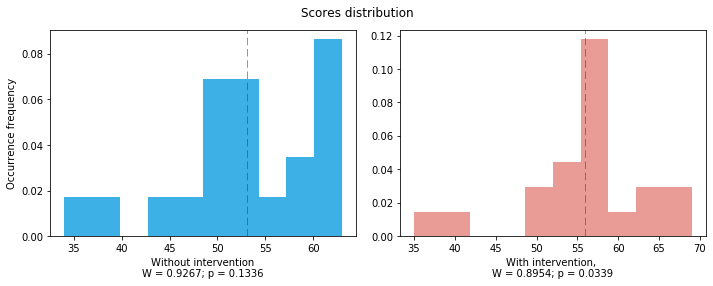

In [13]:
[W_wo, p_wo] = stats.shapiro(resWithoutCountSum.dropna())
[W_w, p_w] = stats.shapiro(resWithCountSum.dropna())

fig, (histC1, histC2) = plt.subplots(1, 2, figsize = (10,4))

histC1.hist(resWithoutCountSum, density=True, bins=10, color="#3DB1E5")
histC1.set(xlabel="Without intervention\nW = %.4f; p = %.4f" % (W_wo, p_wo), ylabel="Occurrence frequency")
histC1.axvline(x=resWithoutCountSum.mean(), color="#444444", alpha=0.75, lw=0.75).set_dashes([10, 5])

histC2.hist(resWithCountSum, density=True, bins=10, color="#E99B96")
histC2.set(xlabel=f"With intervention, \nW = %.4f; p = %.4f" % (W_w, p_w))
histC2.axvline(x=resWithCountSum.mean(), color="#444444", alpha=0.75, lw=0.75).set_dashes([10, 5])

plt.suptitle("Scores distribution")
plt.tight_layout(pad=1, w_pad=1.5, h_pad=1.0)
plt.subplots_adjust(top=0.9)

plt.show()

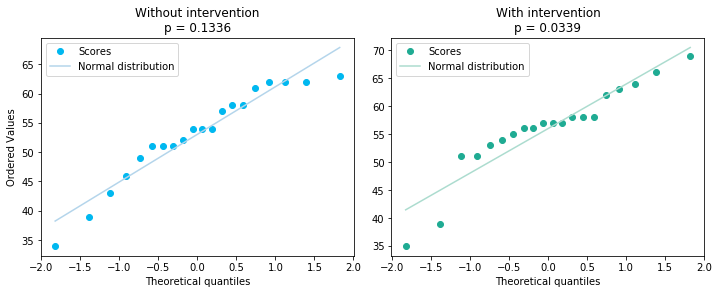

In [33]:
fig = plt.figure(figsize = (10, 4))

ax_wo = fig.add_subplot(121)
QQWithout = stats.probplot(resWithoutCountSum.dropna(), plot=plt)
ax_wo.get_lines()[0].set_markerfacecolor("#00B8F0")
ax_wo.get_lines()[0].set_color("#00B8F0")
ax_wo.get_lines()[1].set_color("#B4D5EB")
ax_wo.set_title("Without intervention\np = %.4f" % p_wo)
ax_wo.legend(["Scores", "Normal distribution"])

ax_w = fig.add_subplot(122)
QQWith = stats.probplot(resWithCountSum.dropna(), plot=plt)
ax_w.get_lines()[0].set_markerfacecolor("#1FAB93")
ax_w.get_lines()[0].set_color("#1FAB93")
ax_w.get_lines()[1].set_color("#ACDCCF")
ax_w.set_title("With intervention\np = %.4f" % p_w)
ax_w.set_ylabel("")
ax_w.legend(["Scores", "Normal distribution"])

plt.tight_layout(pad=1, w_pad=1.5, h_pad=1.0)
plt.subplots_adjust(top=0.9)

plt.show()

The probability value for group without intervention is well over 0.05 and therefore the distribution can be safely considered as normal. For the group with intervention, the probability value is less than 0.05 and it is visible, that the distribution is not normal with all the scores. However, since we are dealing with a small sample size and 3,39% is not radically different from 5%, we will treat both datasets as normally distributed.

# T-Test

**$H_0$:** There is no statistically significant difference between the population (i.e. without intervention) and the chosen sample (i.e. with intervention)

The null hypothesis is to be rejected, if the probability value of the T-test is smaller than the significance level $\alpha$: 0.05

In [37]:
# the method returns the value of the statistic (t) and the probability value (p)
t, p = stats.ttest_ind(resWithoutCountSum.dropna(), resWithCountSum.dropna())
print ('T-stat: %.4f' % t, '\np-value: %.4f' % p)

T-stat: -1.1449 
p-value: 0.2594


**Since p < a (0.05) we say that the null hypothesis is rejected and suggest an alternative: **
**There is a statistically significant difference between the population (i.e. without intervention) and the chosen sample (i.e. with intervention). With that being said,**

## The intervention has an effect on the users' karaoke experience.